<a href="https://www.kaggle.com/code/praneetharao/classifying-audio-using-cnn?scriptVersionId=242965197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import librosa

In [2]:
base_path = '/kaggle/input/cnnmodel'
train_audio_dir = os.path.join(base_path, 'train', 'train')
test_audio_dir = os.path.join(base_path, 'test', 'test')
train_meta_path = os.path.join(base_path, 'metadata of train set .csv')
test_meta_path = os.path.join(base_path, 'metadata of test set.csv')

In [3]:
train_meta = pd.read_csv(train_meta_path)
test_meta = pd.read_csv(test_meta_path)

train_files = os.listdir(train_audio_dir)
test_files = os.listdir(test_audio_dir)

train_meta.head()

,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/


In [4]:
train_files[:5]

['176-cough-aigei-2_1_0.wav',
 'k8fI3Kkm3GM-616_0_0.wav',
 'W7rJpRqK-8E(m)-172_3_0.wav',
 '507408-118_4_0.wav',
 '110=10-man crying-aigei-5_2_0.wav']

In [5]:
train_meta = train_meta[train_meta['Filename'].isin(train_files)]
test_meta = test_meta[test_meta['Filename'].isin(test_files)]

# only keeps rows where the Filename is actually present in the directory
# After this, every row in train_meta corresponds to a real audio file you can access and use

In [6]:
print("Top 5 files in train/train:", train_files[:5])
print("Top 5 files in test/test:", test_files[:5])
print("\nMetadata files:")
for f in os.listdir(base_path):
    if f.endswith('.csv'):
        print(f)

Top 5 files in train/train: ['176-cough-aigei-2_1_0.wav', 'k8fI3Kkm3GM-616_0_0.wav', 'W7rJpRqK-8E(m)-172_3_0.wav', '507408-118_4_0.wav', '110=10-man crying-aigei-5_2_0.wav']
Top 5 files in test/test: ['109759-1_3_0.wav', '508117_1_0.wav', '540771_5_0.wav', '417750_6_0.wav', '127005-10_2_0.wav']

Metadata files:
metadata of test set.csv
metadata of train set .csv


In [7]:
from IPython.display import Audio, display
import random

# Randomly sample 5 files
random_train_files = random.sample(train_files, 5)

for i, f in enumerate(random_train_files, 1):
    meta_row = train_meta[train_meta['Filename'] == f]
    label = meta_row['Classname'].values[0] if not meta_row.empty else "Unknown"
    print(f"{i}. {f} | Label: {label}")
    display(Audio(os.path.join(train_audio_dir, f)))

1. 596=KKKId0LDwVc-41_2_0.wav | Label: crying


2. 32-screaming-aigei-1_4_0.wav | Label: screaming


3. 3-cough-aigei-6_1_0.wav | Label: cough


4. 57=KKKId0LDwVc-297_2_0.wav | Label: crying


5. 403338-1_0_0.wav | Label: breath


In [8]:
print("Rows in metadata before filtering:", len(pd.read_csv(train_meta_path)))
print("Rows in metadata after filtering:", len(train_meta))
print("Number of audio files:", len(train_files))

print("Rows in metadata before filtering:", len(pd.read_csv(test_meta_path)))
print("Rows in metadata after filtering:", len(test_meta))
print("Number of audio files:", len(test_files))

Rows in metadata before filtering: 6289
Rows in metadata after filtering: 6289
Number of audio files: 6289
Rows in metadata before filtering: 725
Rows in metadata after filtering: 725
Number of audio files: 725


In [9]:
import IPython.display as ipd
audio1 = "/kaggle/input/cnnmodel/train/train/176-cough-aigei-2_1_0.wav"

data,sr1=librosa.load(audio1)
ipd.Audio(audio1)

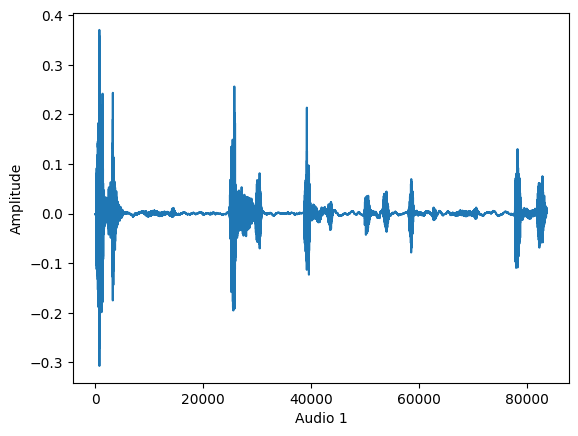

In [10]:
import matplotlib.pyplot as plt

plt.plot(data)
plt.xlabel('Audio 1')
plt.ylabel('Amplitude')
plt.show()

In [11]:
from scipy.io import wavfile as wav
wavesr2, wave_audio=wav.read(audio1)

wavesr2 # sample rate

32000

In [12]:
wave_audio # audio data - each value representing the amplitude of audio at specific time point

array([-4622337, -4625494, -4706050, ...,  7419006,  7980853,  6194682],
      dtype=int32)

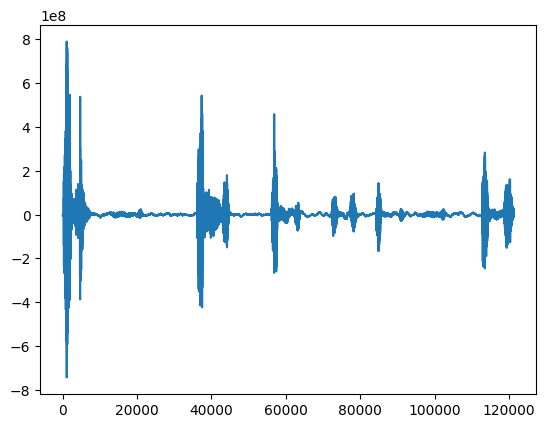

In [13]:
plt.plot(wave_audio)
plt.show()

In [14]:
print("Distinct class names in train set:")
print(train_meta['Classname'].unique())

Distinct class names in train set:
['breath' 'cough' 'crying' 'laugh' 'screaming' 'sneeze' 'yawn']


In [15]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint
from datetime import datetime

2025-05-31 21:15:14.726716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748726115.010490      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748726115.092805      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 100  

# will give a list of (timesteps, n_mfcc) arrays
extracted_features = []
labels = []

def features_extractor(file, n_mfcc=40):
    audio, sample_rate = librosa.load(file, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs.T

for idx, row in tqdm(train_meta.iterrows(), total=len(train_meta)):
    file_path = os.path.join(train_audio_dir, row['Filename'])
    try:
        mfccs = features_extractor(file_path, n_mfcc=40)
        extracted_features.append(mfccs)
        labels.append(row['Classname'])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


X = pad_sequences(extracted_features, maxlen=max_len, dtype='float32', padding='post', truncating='post')
print(X.shape)  # (num_samples, max_len, n_mfcc)

100%|██████████| 6289/6289 [03:14<00:00, 32.39it/s]


(6289, 100, 40)


In [17]:
print(extracted_features[:1])

[array([[-433.17142   ,   82.43711   ,  -41.890083  , ...,    0.59940696,
          -2.0055525 ,    1.4395136 ],
       [-402.24548   ,   83.66145   ,  -46.23065   , ...,   -2.4767628 ,
           0.9815416 ,    2.9446335 ],
       [-391.43762   ,   81.4756    ,  -49.59252   , ...,    1.7878046 ,
           2.7928345 ,    5.384738  ],
       ...,
       [-323.27676   ,   32.434227  ,  -30.69798   , ...,    5.914466  ,
           1.8558023 ,   10.641914  ],
       [-319.45416   ,   35.14482   ,  -24.460228  , ...,    8.285009  ,
           6.6594634 ,    8.84806   ],
       [-341.35205   ,   39.30413   ,  -16.875473  , ...,   11.0975065 ,
           6.0040727 ,    7.3684864 ]], dtype=float32)]


In [18]:
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_cat = to_categorical(y_encoded)
print("Classes:", le.classes_)
print("Number of labels:", len(labels))

Classes: ['breath' 'cough' 'crying' 'laugh' 'screaming' 'sneeze' 'yawn']
Number of labels: 6289


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)


In [20]:
from tensorflow.keras import layers,models
from tensorflow.keras import Input

num_labels = y_cat.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2])  # (max_len, n_mfcc)

model = models.Sequential()
# model.add(layers.Conv1D(32, kernel_size=5, input_shape=input_shape))
model.add(Input(shape=input_shape))
model.add(layers.Conv1D(32, kernel_size=5))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=1))
model.add(layers.Conv1D(64, kernel_size=5))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=1))
model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

2025-05-31 21:18:46.524324: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 96, 32)              │           6,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 96, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 96, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 92, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 92, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 92, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 92, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5888)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         753,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,327 (2.95 MB)

 Trainable params: 771,879 (2.94 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
print("Number of classes in labels:", y_cat.shape[1])

Number of classes in labels: 7


In [22]:
num_epochs = 20
num_batch_size = 4

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from datetime import datetime

# ModelCheckpoint: save the whole model
checkpointer = ModelCheckpoint(filepath='best_model.keras', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start = datetime.now()
history = model.fit(
    X_train, y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_val, y_val),
    callbacks=[checkpointer, earlystop],
    verbose=1
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
1257/1258 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4315 - loss: 1.7019
Epoch 1: val_loss improved from inf to 1.10863, saving model to best_model.keras
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.4316 - loss: 1.7016 - val_accuracy: 0.5946 - val_loss: 1.1086
Epoch 2/20
1256/1258 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5262 - loss: 1.2785
Epoch 2: val_loss improved from 1.10863 to 0.92499, saving model to best_model.keras
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5263 - loss: 1.2785 - val_accuracy: 0.6749 - val_loss: 0.9250
Epoch 3/20
1256/1258 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5705 - loss: 1.1316
Epoch 3: val_loss improved from 0.92499 to 0.87578, saving model to best_model.keras
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5705 - loss: 1.1316 - val_accuracy: 0.6987 - val_loss: 0.8758
Epoch 4/20
1255/1258 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6068 - loss: 1.0967
Epoch 4: val_loss improved from 0

In [23]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation set accuracy: {val_acc * 100:.2f}%")


Validation set accuracy: 79.57%


In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict class probabilities for validation set
y_pred_probs = model.predict(X_val)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
cm = confusion_matrix(y_true, y_pred)

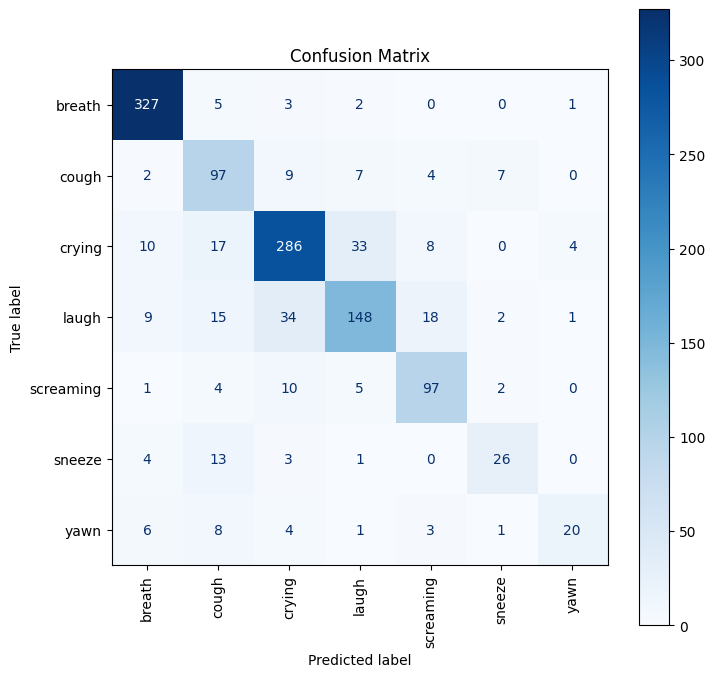

In [26]:
# If you have label names from your LabelEncoder
labels = le.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [27]:
test_extracted_features = []
test_labels = []

for idx, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
    file_path = os.path.join(test_audio_dir, row['Filename'])
    try:
        mfccs = features_extractor(file_path, n_mfcc=40)
        test_extracted_features.append(mfccs)
        test_labels.append(row['Classname']) 
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

100%|██████████| 725/725 [00:20<00:00, 35.81it/s]


In [28]:
print("Unique train labels:", sorted(set(labels)))
print("Unique test labels:", sorted(set(test_labels)))

Unique train labels: ['breath', 'cough', 'crying', 'laugh', 'screaming', 'sneeze', 'yawn']
Unique test labels: ['breath', 'cough', 'crying', 'laugh', 'screaming', 'sneeze', 'yawm']


In [29]:
# Fix common typos in test labels
test_labels = [lbl.replace('yawm', 'yawn') for lbl in test_labels]


y_test_encoded = le.transform(test_labels)
y_test_cat = to_categorical(y_test_encoded)

In [30]:
X_test = pad_sequences(test_extracted_features, maxlen=max_len, dtype='float32', padding='post', truncating='post')
print(X_test.shape)  # (num_test_samples, max_len, n_mfcc)

y_test_encoded = le.transform(test_labels)
y_test_cat = to_categorical(y_test_encoded)

(725, 100, 40)


In [31]:
test_pred_probs = model.predict(X_test)
test_pred_indices = np.argmax(test_pred_probs, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Test set accuracy: 64.55%
Classification Report:
              precision    recall  f1-score   support

      breath       0.83      0.75      0.79       160
       cough       0.41      0.86      0.56        70
      crying       0.74      0.51      0.61       205
       laugh       0.72      0.71      0.71       140
   screaming       0.53      0.63      0.58        70
      sneeze       0.41      0.47      0.44        30
        yawn       0.65      0.52      0.58        50

    accuracy                           0.65       725
   macro avg       0.61      0.63      0.61       725
weighted avg       0.69      0.65      0.65       725



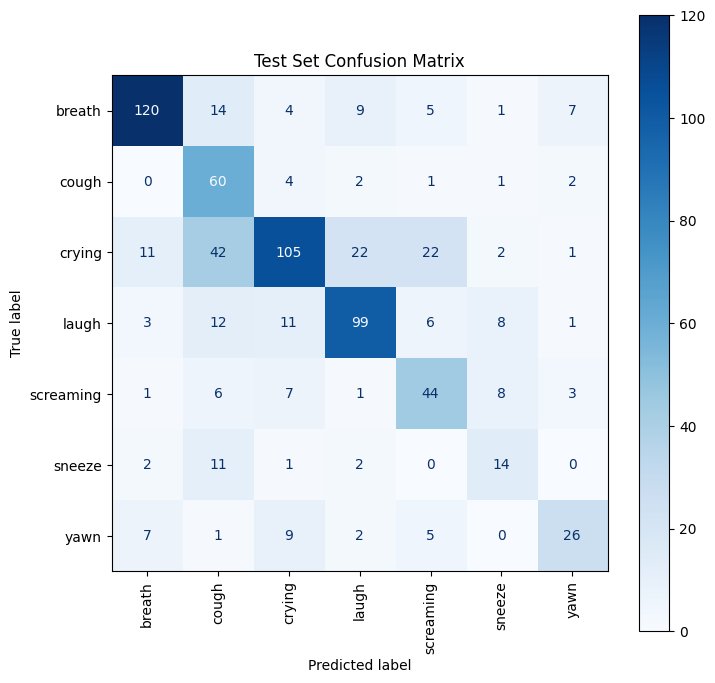

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test_encoded, test_pred_indices)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test_encoded, test_pred_indices, target_names=le.classes_))


cm = confusion_matrix(y_test_encoded, test_pred_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title("Test Set Confusion Matrix")
plt.show()

In [33]:
example = 10

sample_X = X_test[example:example+1]  # shape (1, max_len, n_mfcc)

sample_pred_probs = model.predict(sample_X)
sample_pred_idx = np.argmax(sample_pred_probs, axis=1)[0]
sample_pred_label = le.inverse_transform([sample_pred_idx])[0]


true_label_idx = y_test_encoded[example]
true_label = le.inverse_transform([true_label_idx])[0]


sample_filename = test_meta.iloc[example]['Filename']


print(f"Test sample index: {example}")
print(f"Filename:         {sample_filename}")
print(f"Predicted label:  {sample_pred_label}")
print(f"True label:       {true_label}")


display(Audio(os.path.join(test_audio_dir, sample_filename)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test sample index: 10
Filename:         144128-7_0_0.wav
Predicted label:  breath
True label:       breath
